# **Introduction**


## Importing the required modules


In [11]:
!pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7

In [5]:
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import os, time, warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)

warnings.filterwarnings("ignore")


In [6]:
log_cols = ["model", "accuracy", "train_time", "pred_time"]
log = pd.DataFrame(columns=log_cols)


## Reading the data


In [7]:

meta_data = pd.read_csv("output.csv")
meta_data.head()


,Label,File Name
0,advice,D:\dys\Module 2\Disarthria-20240315T142530Z-00...
1,advice,D:\dys\Module 2\Disarthria-20240315T142530Z-00...
2,advice,D:\dys\Module 2\Disarthria-20240315T142530Z-00...
3,advice,D:\dys\Module 2\Disarthria-20240315T142530Z-00...
4,advice,D:\dys\Module 2\Disarthria-20240315T142530Z-00...


In [8]:
meta_data.groupby("Label")["Label"].unique()


Label
BOTH              [BOTH]
Backspace    [Backspace]
Command        [Command]
Delete          [Delete]
LIKE              [LIKE]
THEN              [THEN]
advice          [advice]
car                [car]
come              [come]
enter            [enter]
find              [find]
five              [five]
four              [four]
get                [get]
he                  [he]
many              [many]
number          [number]
one                [one]
orange          [orange]
people          [people]
they              [they]
Name: Label, dtype: object

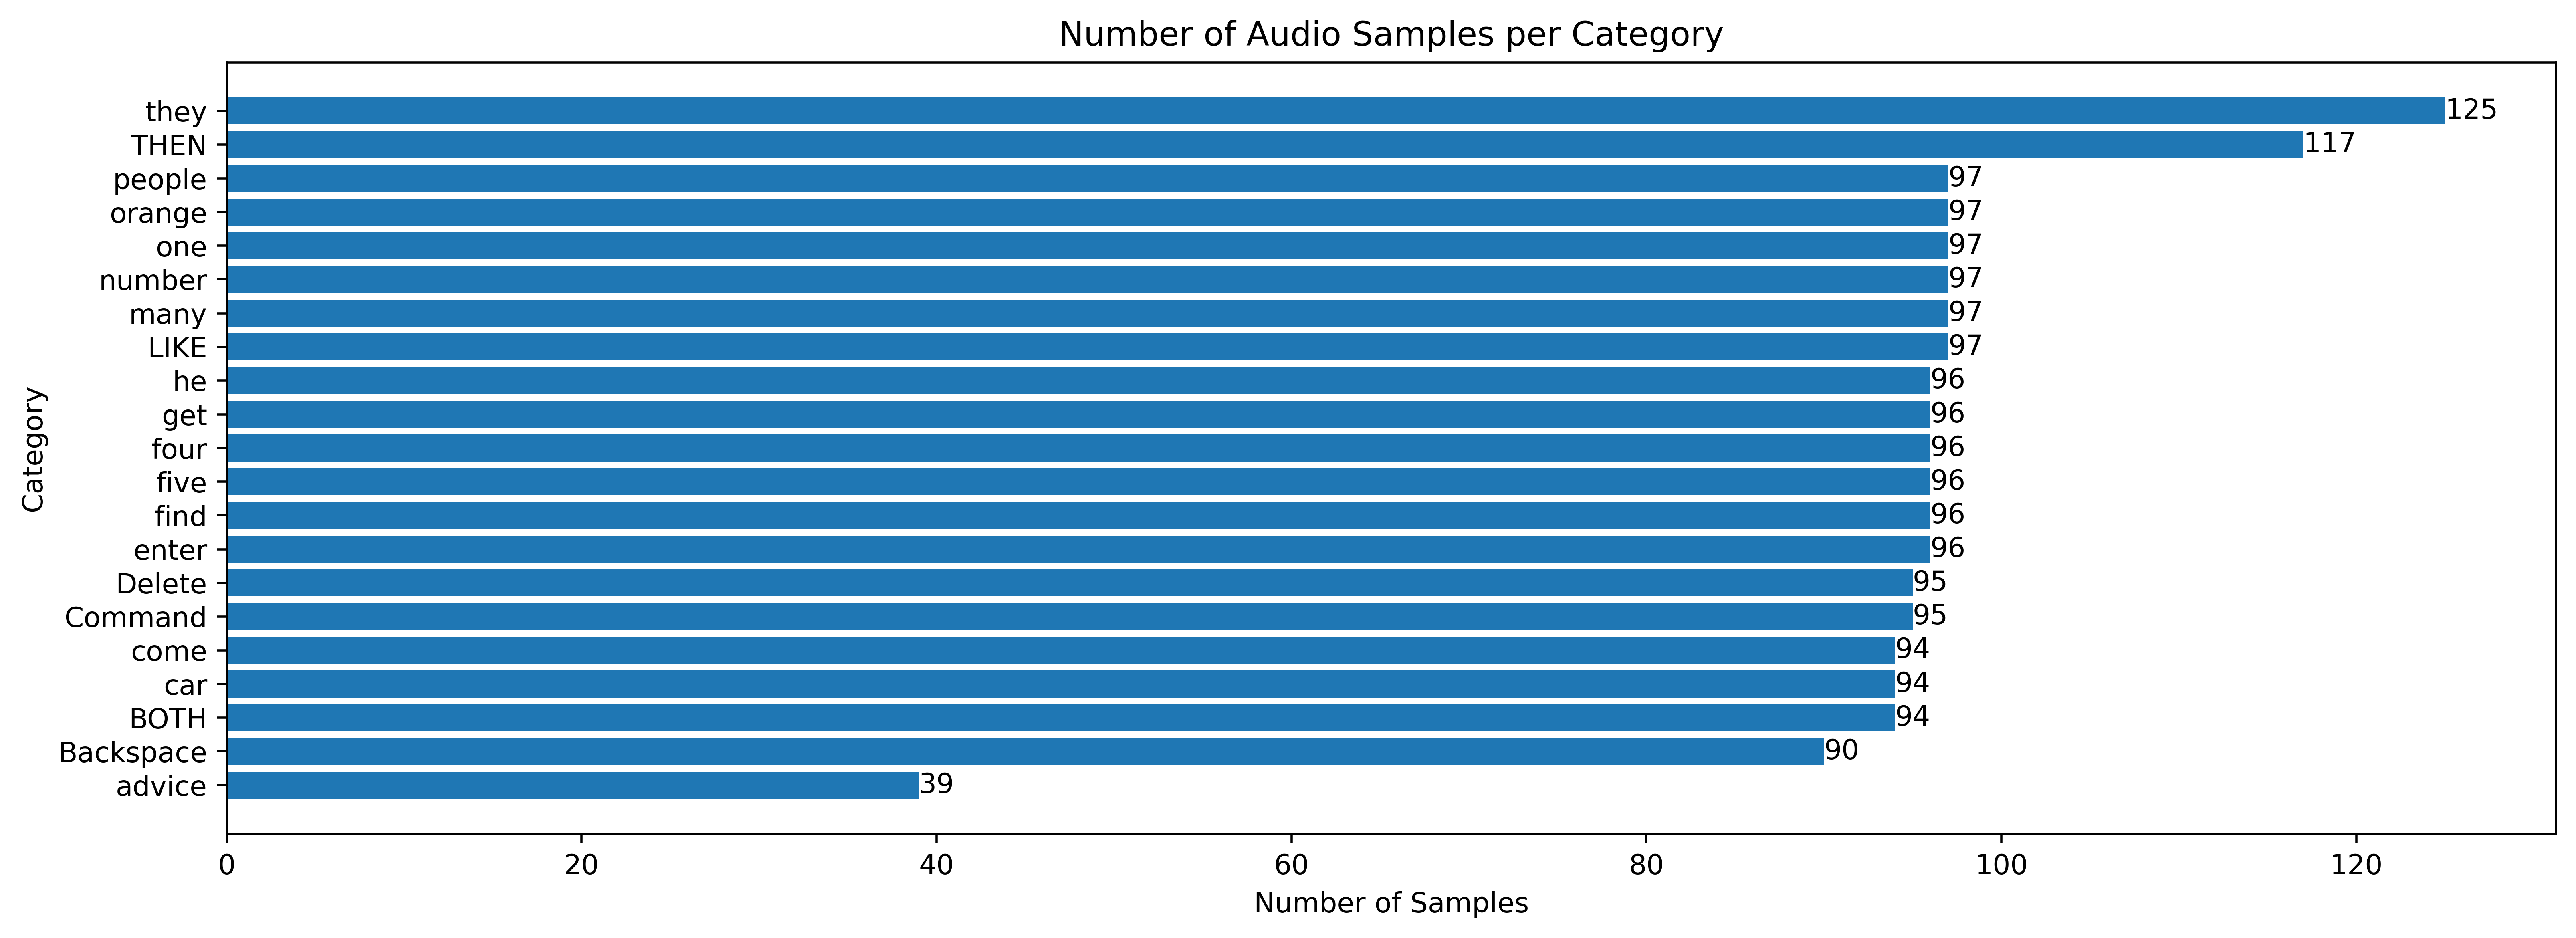

In [9]:
x = meta_data["Label"].unique()
y = meta_data["Label"].value_counts(ascending=True)
ind = np.arange(len(y))
# plt.figure()
fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(ind, y)
ax.set_yticks(ind)
ax.set_yticklabels(x)
ax.bar_label(ax.containers[0])
plt.gcf().set_dpi(500)
plt.title("Number of Audio Samples per Category")
plt.xlabel("Number of Samples")
plt.ylabel("Category")
plt.show()


# **MFCC Visualization**


In [10]:
plt.rcParams["figure.figsize"] = (5, 2.5)
plt.rcParams["figure.dpi"] = 200


<function matplotlib.pyplot.show(close=None, block=None)>

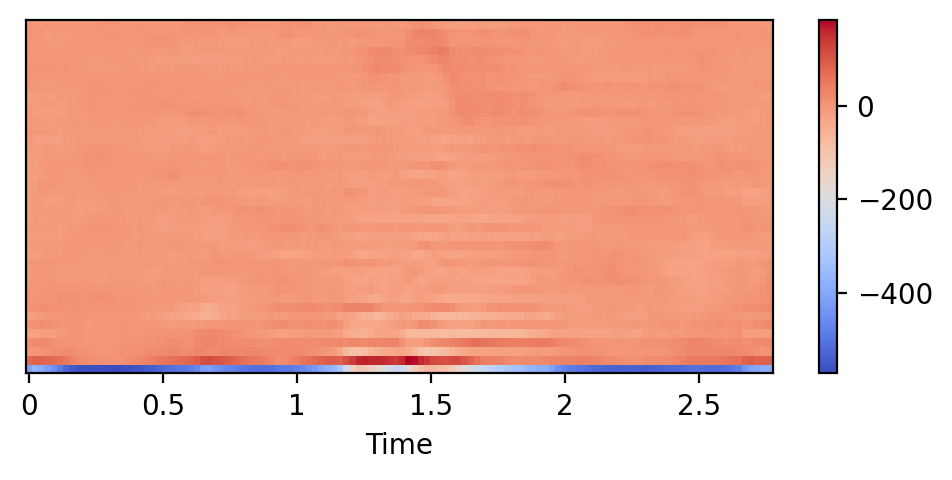

In [11]:
audio_path = meta_data['File Name'][20]
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

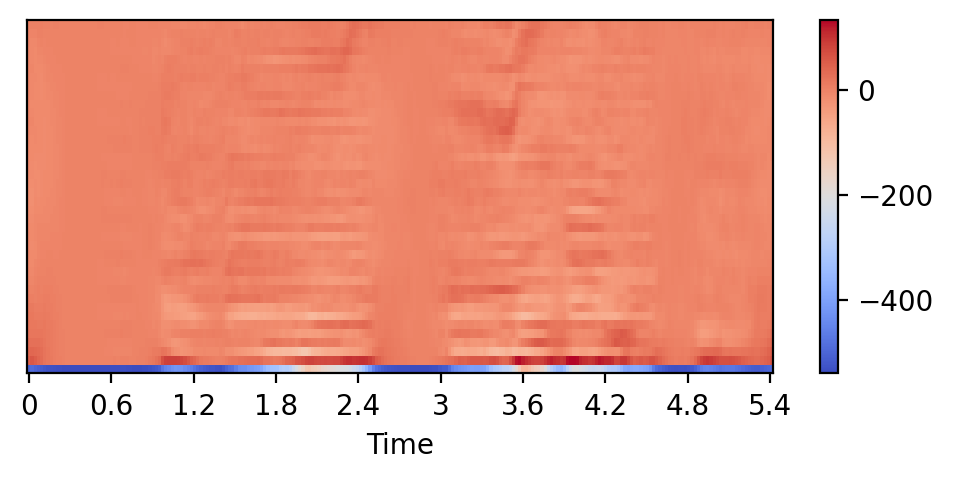

In [12]:
audio_path = meta_data['File Name'][50]
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

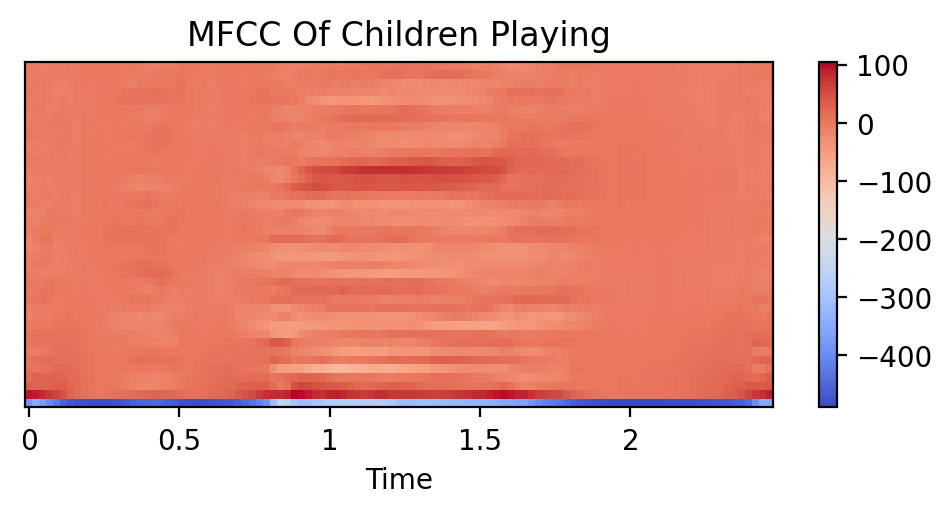

In [13]:
audio_path = meta_data['File Name'][400]
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Children Playing")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

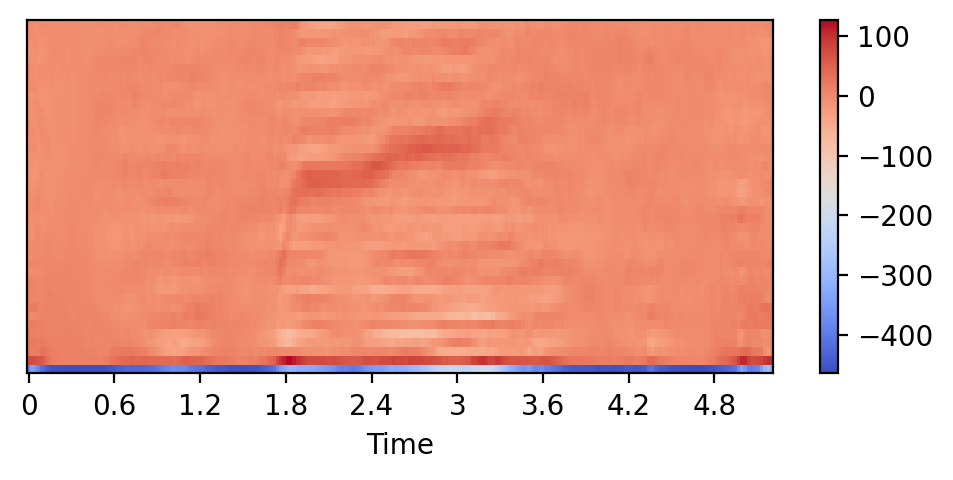

In [14]:
audio_path = meta_data['File Name'][300]
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

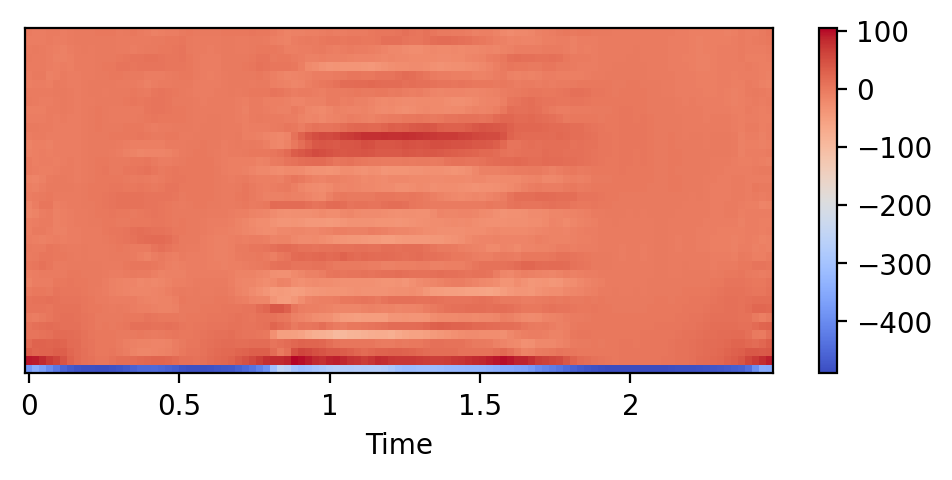

In [15]:
audio_path = meta_data['File Name'][400]
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.show


# **Feature Extraction and Database Building**

## Method

1. I have used Librosa to preprocess audio file.
2. To do so, I will go through each fold and extract the data from each file using librosa's mfcc function.
3. The extracted data is appended in a list and stored in a dataframe.

### The function bellow will extract mfcc feature

In [30]:

!pip install resampy==0.1.5

     ---------------------------------------- 0.0/444.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/444.6 kB ? eta -:--:--
      --------------------------------------- 10.2/444.6 kB ? eta -:--:--
      --------------------------------------- 10.2/444.6 kB ? eta -:--:--
      --------------------------------------- 10.2/444.6 kB ? eta -:--:--
     -- ---------------------------------- 30.7/444.6 kB 146.3 kB/s eta 0:00:03
     --- --------------------------------- 41.0/444.6 kB 151.3 kB/s eta 0:00:03
     ----- ------------------------------- 61.4/444.6 kB 204.8 kB/s eta 0:00:02
     ------- ----------------------------- 92.2/444.6 kB 262.6 kB/s eta 0:00:02
     ----------- ------------------------ 143.4/444.6 kB 355.0 kB/s eta 0:00:01
     ---------------- ------------------- 204.8/444.6 kB 461.0 kB/s eta 0:00:01
     ------------------- ---------------- 245.8/444.6 kB 519.9 kB/s eta 0:00:01
     ----------------------------- ------ 358.4/444.6 kB 676.0 kB/s eta 

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  C:\Users\mianj\AppData\Local\Temp\pip-install-fv7rdufh\resampy_4bcba3544ac74f30a4a1d676fb2405fb\setup.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
    import imp
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\resampy
  copying resampy\core.py -> build\lib.win-amd64-cpython-311\resampy
  copying resampy\filters.py -> build\lib.win-amd64-cpython-311\resampy
  copying resampy\version.py -> build\lib.win-amd64-cpython-311\resampy
  copying resampy\__init__.py -> build\lib.win-amd64-cpython-311\resampy
  creating build\lib.win-amd64-cpython-311\resampy\data
  copying resampy\data\kaiser_best.npz -> build\lib.win-amd64-cp

In [16]:
extracted = []

for index_num, row in tqdm(meta_data.iterrows()):
    file_name = row['File Name']
    final_class_labels = row["Label"]
    audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    feature = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    scaled_feature = np.mean(feature.T, axis=0)
    extracted.append([scaled_feature, final_class_labels])


2001it [02:42, 12.31it/s]


# **Data Preprocessing**


### Using a dataframe and pickle to save the extracted features array

In [17]:
# create a new dataframe
extracted_df = pd.DataFrame(extracted, columns=["feature", "class"])
# Storing the dataframe to pickle for further processing
extracted_df.to_pickle("extracted_df.pkl")
extracted_df.head()


,feature,class
0,"[-423.1933, 66.29867, 6.0135026, -0.27168238, ...",advice
1,"[-430.08023, 61.36307, 2.5803854, -5.741271, -...",advice
2,"[-415.2581, 66.906296, 8.362711, -3.4642174, -...",advice
3,"[-415.04443, 65.14238, 8.965137, 0.9474892, -1...",advice
4,"[-422.9452, 68.45039, 7.728566, -3.7733142, -1...",advice


## Distribute the data to X and Y


In [18]:
final = pd.DataFrame(extracted, columns=["feature", "class"])
X = np.array(final["feature"].tolist())
y = np.array(final["class"].tolist())


## Using LabelEncoder() to encode the string labels to an integer


In [19]:
le = LabelEncoder()
Y = to_categorical(le.fit_transform(y))


## Split the data into train and test sets


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


In [21]:
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])

Number of training samples =  1600
Number of testing samples =  401


# **Model 2 - CNN1D**


## Preprocessing


In [22]:
xTrainval, xTest, yTrainval, yTest = train_test_split(
    X, Y, test_size=0.1, stratify=y, random_state=387
)
xTrain, xvalid, yTrain, yvalid = train_test_split(
    xTrainval, yTrainval, test_size=0.2, stratify=yTrainval, random_state=387
)
print("\nNumber of samples for Train set :", xTrain.shape[0])
print("Number of samples for Validation set :", xvalid.shape[0])
print("Number of samples for Test set :", xTest.shape[0])

xTrain = np.expand_dims(xTrain, axis=2)
xvalid = np.expand_dims(xvalid, axis=2)

print("Shape of X Train", xTrain.shape)
print("Shape of X Test", xTest.shape)



Number of samples for Train set : 1440
Number of samples for Validation set : 360
Number of samples for Test set : 201
Shape of X Train (1440, 128, 1)
Shape of X Test (201, 128)


## Building the CNN1D Model


In [23]:
CNN1D_Model1 = Sequential()
CNN1D_Model1.add(
    Conv1D(
        256,
        5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(xTrain.shape[1], 1),
    )
)
CNN1D_Model1.add(BatchNormalization())
CNN1D_Model1.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model1.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model1.add(Dropout(0.3))
CNN1D_Model1.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model1.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model1.add(Dropout(0.3))
CNN1D_Model1.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model1.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model1.add(Dropout(0.3))
CNN1D_Model1.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model1.add(Flatten())
CNN1D_Model1.add(Dense(units=1024, activation="relu"))
CNN1D_Model1.add(Dropout(0.3))
CNN1D_Model1.add(Dense(units=21, activation="softmax"))
CNN1D_Model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 128, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 64, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 32, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 16, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 21)                  │          21,525 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,082,325 (4.13 MB)

 Trainable params: 1,081,813 (4.13 MB)

 Non-trainable params: 512 (2.00 KB)

## Compiling the Model


In [24]:
CNN1D_Model1.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


## Fitting the Model


In [25]:
!pip install h5py


In [26]:
t0 = time.time()

CNN1D_Results = CNN1D_Model1.fit(xTrain, yTrain, batch_size=64, epochs=250, validation_data=(xvalid, yvalid))


Epoch 1/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.0547 - loss: 3.4827 - val_accuracy: 0.0444 - val_loss: 3.0835
Epoch 2/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.0664 - loss: 3.0372 - val_accuracy: 0.0833 - val_loss: 3.0172
Epoch 3/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.0874 - loss: 2.9855 - val_accuracy: 0.0833 - val_loss: 2.9861
Epoch 4/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.0904 - loss: 2.9483 - val_accuracy: 0.0889 - val_loss: 2.9702
Epoch 5/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.1008 - loss: 2.8827 - val_accuracy: 0.1361 - val_loss: 2.8863
Epoch 6/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.1152 - loss: 2.7918 - val_accuracy: 0.1167 - val_loss: 2.8463
Epoch 7/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.1333 - loss: 2.7829 - val_accuracy: 0.1111 - val_loss: 2.8544
Epoch 8/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.1339 - loss: 2.7441 - val_a

Epoch 51/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.8600 - loss: 0.4540 - val_accuracy: 0.6222 - val_loss: 1.3096
Epoch 52/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.8738 - loss: 0.4160 - val_accuracy: 0.6167 - val_loss: 1.2968
Epoch 53/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - accuracy: 0.8809 - loss: 0.3597 - val_accuracy: 0.6222 - val_loss: 1.3023
Epoch 54/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.8769 - loss: 0.3887 - val_accuracy: 0.6056 - val_loss: 1.2830
Epoch 55/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.8814 - loss: 0.3515 - val_accuracy: 0.6278 - val_loss: 1.2875
Epoch 56/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.8795 - loss: 0.3760 - val_accuracy: 0.6083 - val_loss: 1.3094
Epoch 57/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.8647 - loss: 0.4276 - val_accuracy: 0.6194 - val_loss: 1.3356
Epoch 58/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.8610 - loss: 0.3880 -

Epoch 101/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.9534 - loss: 0.1252 - val_accuracy: 0.6528 - val_loss: 1.3032
Epoch 102/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.9683 - loss: 0.1282 - val_accuracy: 0.6556 - val_loss: 1.3292
Epoch 103/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9533 - loss: 0.1586 - val_accuracy: 0.6333 - val_loss: 1.3901
Epoch 104/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step - accuracy: 0.9549 - loss: 0.1529 - val_accuracy: 0.6056 - val_loss: 1.3743
Epoch 105/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9599 - loss: 0.1555 - val_accuracy: 0.6556 - val_loss: 1.1793
Epoch 106/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.9506 - loss: 0.1644 - val_accuracy: 0.6167 - val_loss: 1.3587
Epoch 107/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.9536 - loss: 0.1479 - val_accuracy: 0.6472 - val_loss: 1.3244
Epoch 108/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.9643 - loss:

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.9619 - loss: 0.1186 - val_accuracy: 0.5833 - val_loss: 1.7574
Epoch 200/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9674 - loss: 0.1130 - val_accuracy: 0.6250 - val_loss: 1.5429
Epoch 201/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.9826 - loss: 0.0686 - val_accuracy: 0.6639 - val_loss: 1.5853
Epoch 202/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.9613 - loss: 0.1448 - val_accuracy: 0.6250 - val_loss: 1.6701
Epoch 203/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9560 - loss: 0.1977 - val_accuracy: 0.6444 - val_loss: 1.6673
Epoch 204/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.9676 - loss: 0.1014 - val_accuracy: 0.6444 - val_loss: 1.5596
Epoch 205/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.9596 - loss: 0.1235 - val_accuracy: 0.6472 - val_loss: 1.5200
Epoch 206/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.9718 - loss: 0.1019 - val_ac

In [30]:
CNN1D_Model1.save("Model2.keras")
print("CNN1D Model Saved")
train_hist_m2 = pd.DataFrame(CNN1D_Results.history)  # Assuming CNN1D_Results contains history
train_m2 = round(time.time() - t0, 3)


CNN1D Model Saved


## Results


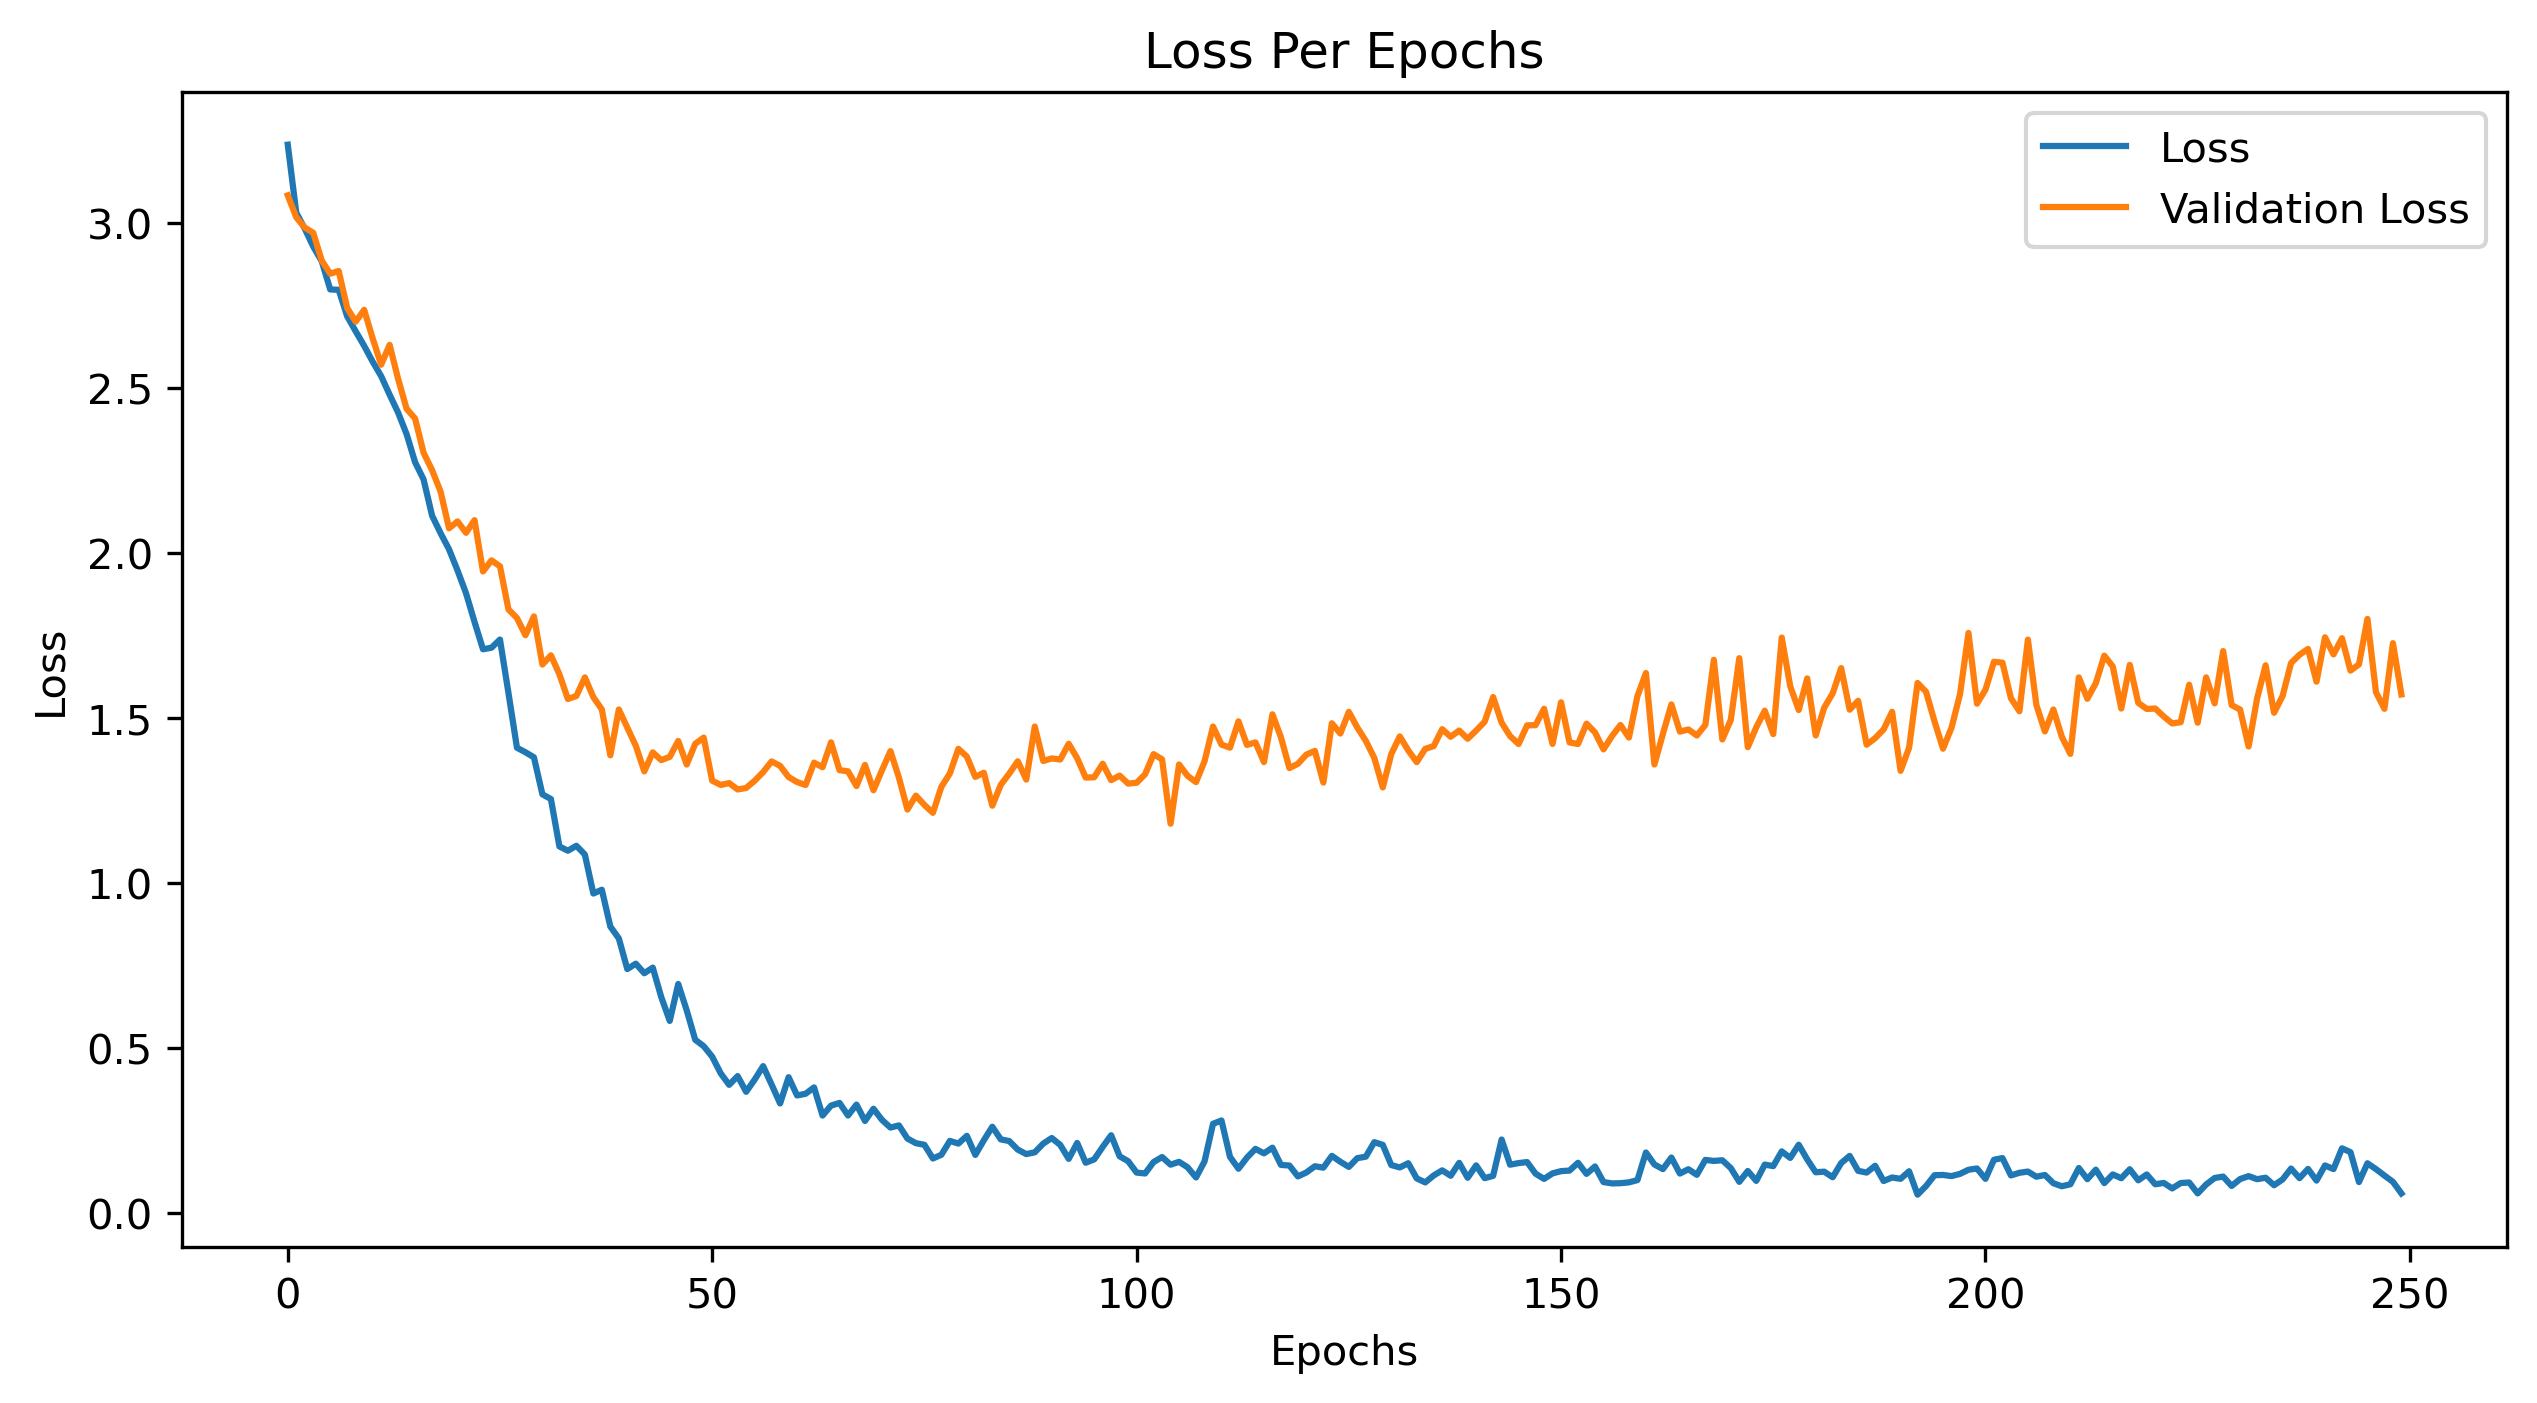

In [31]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


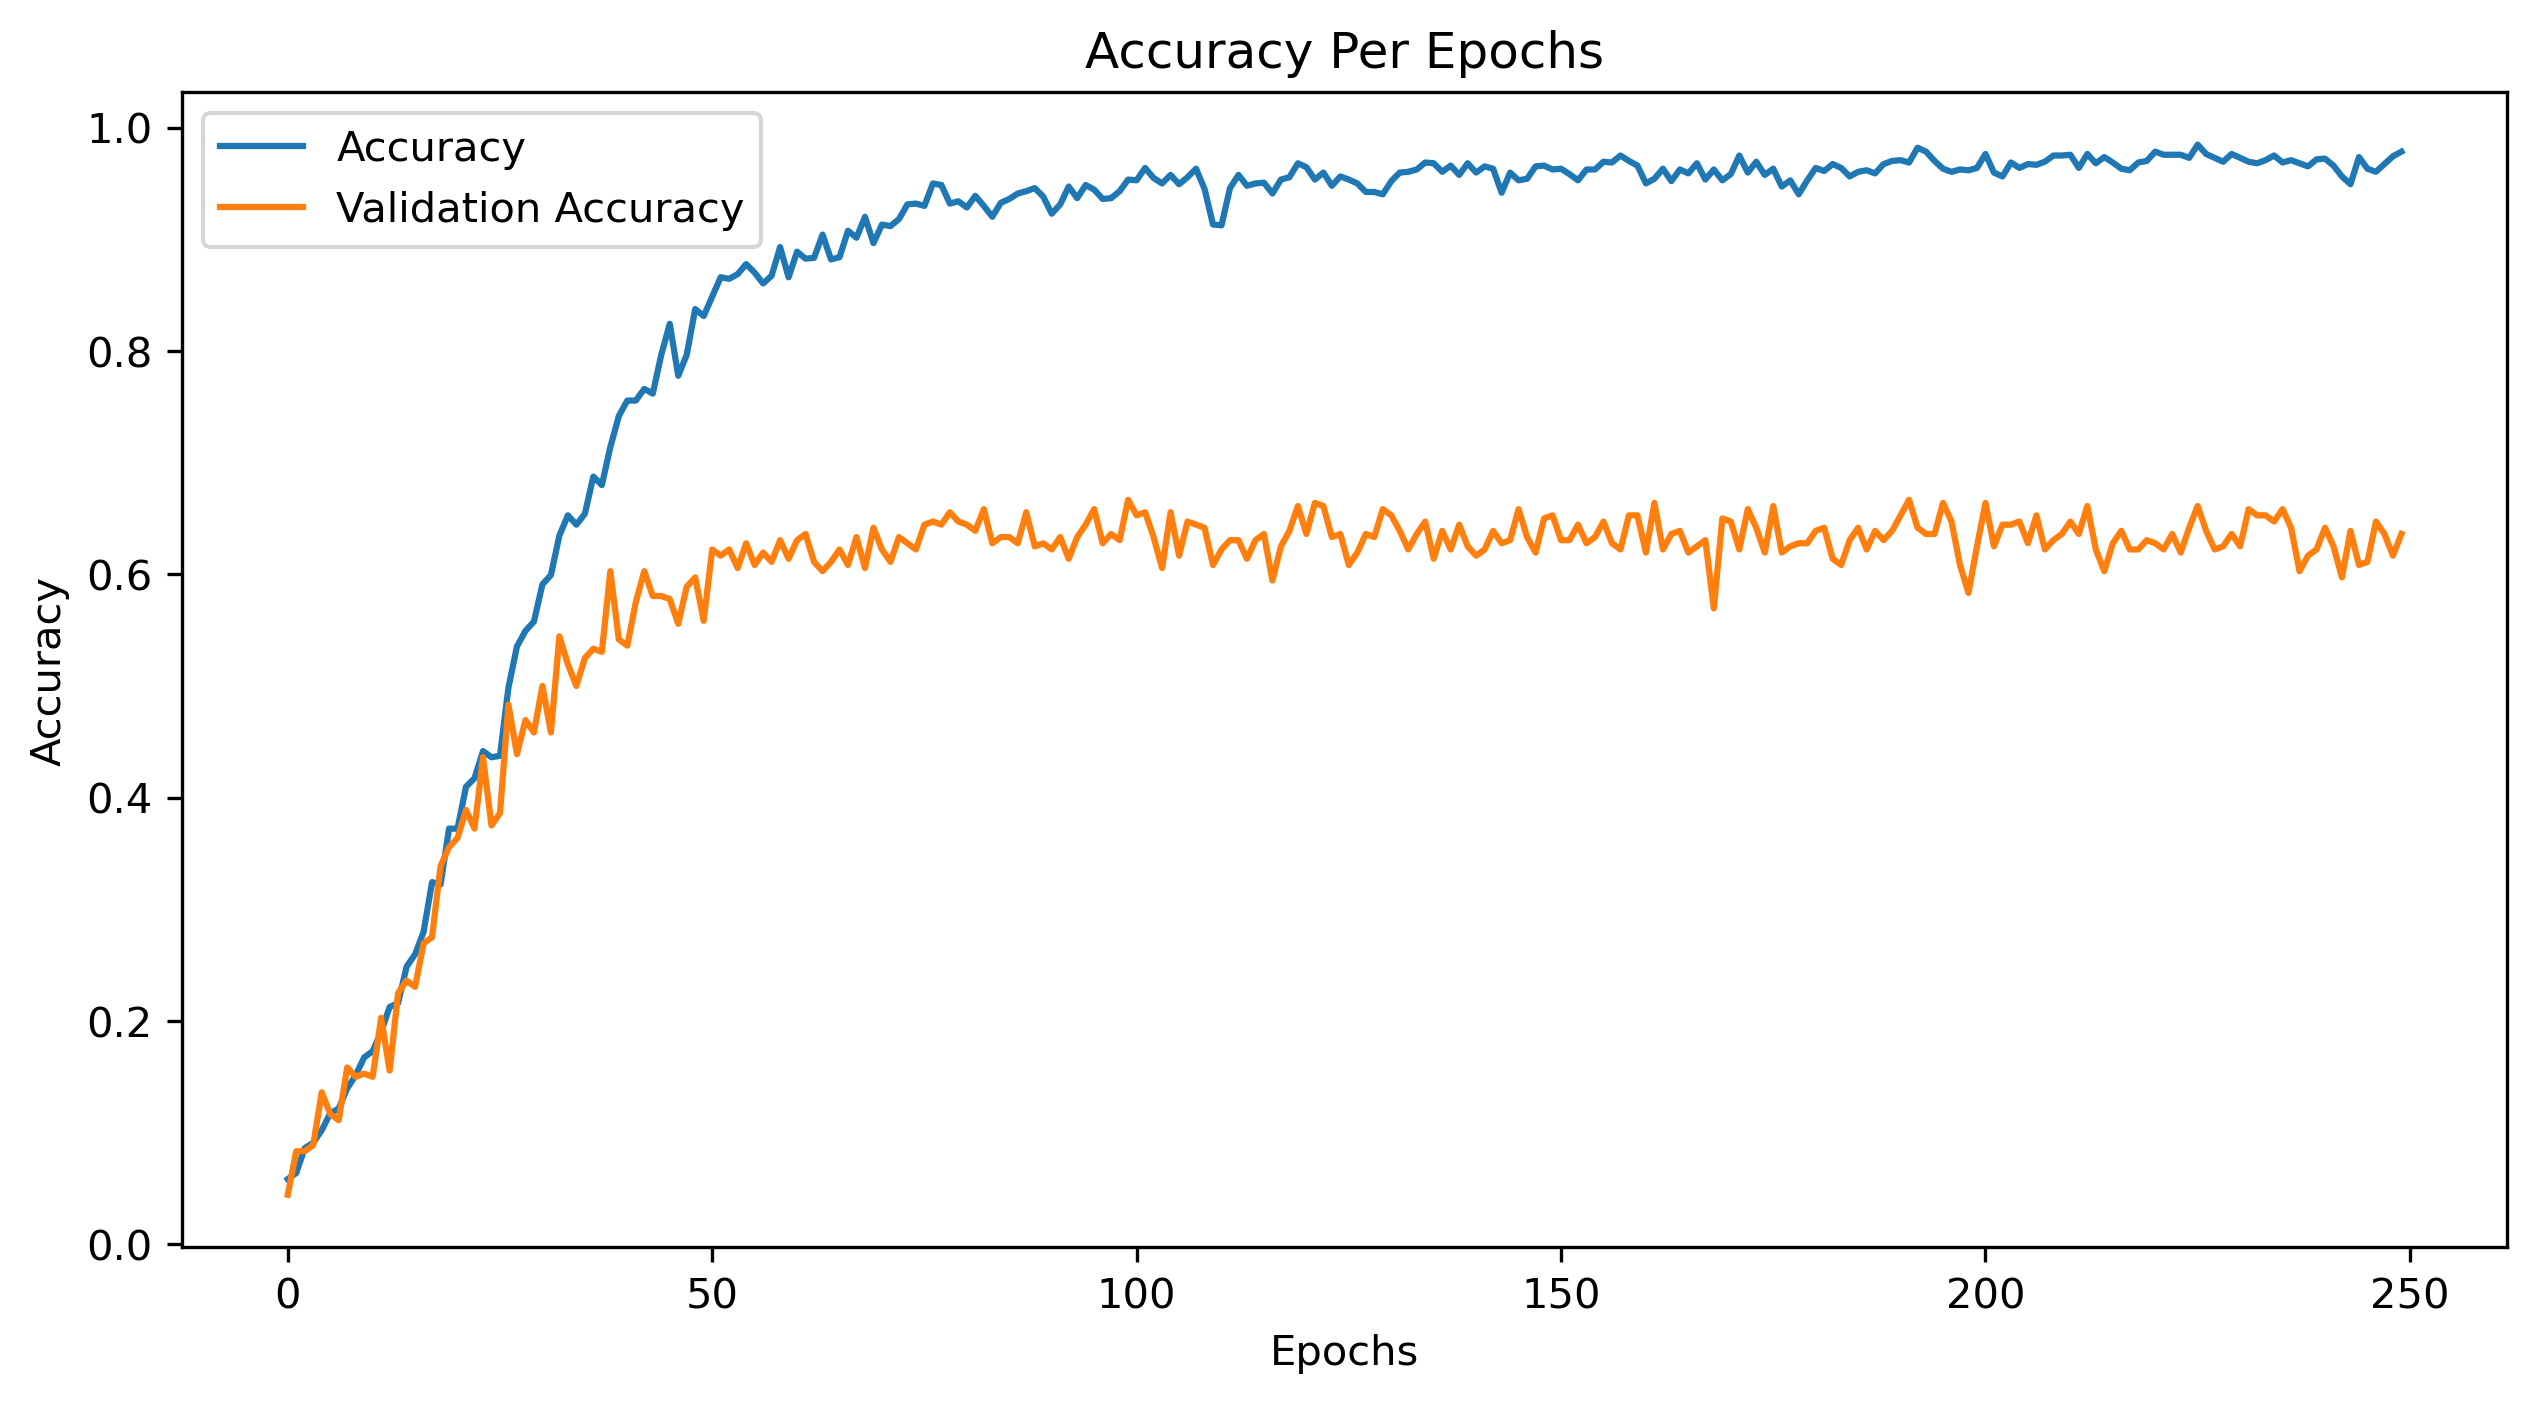

In [32]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [42]:
acc_m2 = CNN1D_Model1.evaluate(xvalid, yvalid, verbose=0)
t0 = time.time()
y_pred_m2 = CNN1D_Model1.predict(xvalid, verbose=0)
pred_m2 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN1D", acc_m2[1] * 100, train_m2, pred_m2]], columns=log_cols
)
log = log.append(log_entry)


AttributeError: 'DataFrame' object has no attribute 'append'

## CNN1D Prediction Function


In [47]:
acc_m2 = CNN1D_Model1.evaluate(xvalid, yvalid, verbose=0)
t0 = time.time()
y_pred_m2 = CNN1D_Model1.predict(xvalid, verbose=0)
pred_m2 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN1D", acc_m2[1] * 100, train_m2, pred_m2]], columns=log_cols
)
log = log.append(log_entry)

AttributeError: 'DataFrame' object has no attribute 'append'

## Testing the Model on Sample audio


In [40]:
# File name
file_name = audio_dataset_path + "fold8/103076-3-0-0.wav"
# get the output
CNN1D_Prediction(file_name)
# play the file
ipd.Audio(file_name)



NameError: name 'audio_dataset_path' is not defined

# **Model 3 - CNN2D**


## Preprocessing


In [14]:
xtrain = xTrain.reshape(xTrain.shape[0], 16, 8, 1)
xtest = xTest.reshape(xTest.shape[0], 16, 8, 1)

print("The Shape of X Train", xtrain.shape)
print("The Shape of Y Train", yTrain.shape)
print("The Shape of X Test", xtest.shape)
print("The Shape of Y Test", yTest.shape)


The Shape of X Train (2096, 16, 8, 1)
The Shape of Y Train (2096, 30)
The Shape of X Test (292, 16, 8, 1)
The Shape of Y Test (292, 30)


## Building the CNN2D Model


In [43]:
CNN2D_Model1 = Sequential()
CNN2D_Model1.add(
    Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1))
)
CNN2D_Model1.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model1.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model1.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model1.add(Dropout(0.4))
CNN2D_Model1.add(Flatten())
CNN2D_Model1.add(Dense(1024, activation="relu"))
CNN2D_Model1.add(Dense(30, activation="softmax"))
CNN2D_Model1.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 2, 128)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 4, 2, 128)         0         
                                                                 
 flatten_9 (Flatten)         (None, 1024)             

## Compiling the Model


In [47]:
CNN2D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


## Fitting the Model


In [48]:
t0 = time.time()

CNN2D_Results = CNN2D_Model.fit(
    xtrain, yTrain, epochs=150, batch_size=256, validation_data=(xtest, yTest)
)

CNN2D_Model.save("Model3.h5")
print("CNN2D Model Saved")
train_hist_m3 = pd.DataFrame(CNN2D_Results.history)
train_m3 = round(time.time() - t0, 3)


Epoch 1/150
9/9 [==============================] - 1s 30ms/step - loss: 3.4485 - accuracy: 0.0444 - val_loss: 3.3370 - val_accuracy: 0.0993
Epoch 2/150
9/9 [==============================] - 0s 18ms/step - loss: 3.2682 - accuracy: 0.0954 - val_loss: 3.2236 - val_accuracy: 0.1404
Epoch 3/150
9/9 [==============================] - 0s 13ms/step - loss: 3.0711 - accuracy: 0.1789 - val_loss: 3.0889 - val_accuracy: 0.1712
Epoch 4/150
9/9 [==============================] - 0s 14ms/step - loss: 2.8139 - accuracy: 0.2462 - val_loss: 2.9531 - val_accuracy: 0.1815
Epoch 5/150
9/9 [==============================] - 0s 13ms/step - loss: 2.5128 - accuracy: 0.3187 - val_loss: 2.7019 - val_accuracy: 0.2500
Epoch 6/150
9/9 [==============================] - 0s 14ms/step - loss: 2.2224 - accuracy: 0.3979 - val_loss: 2.5654 - val_accuracy: 0.2637
Epoch 7/150
9/9 [==============================] - 0s 13ms/step - loss: 1.9362 - accuracy: 0.4704 - val_loss: 2.3446 - val_accuracy: 0.3596
Epoch 8/150
9/9 [===

## Results


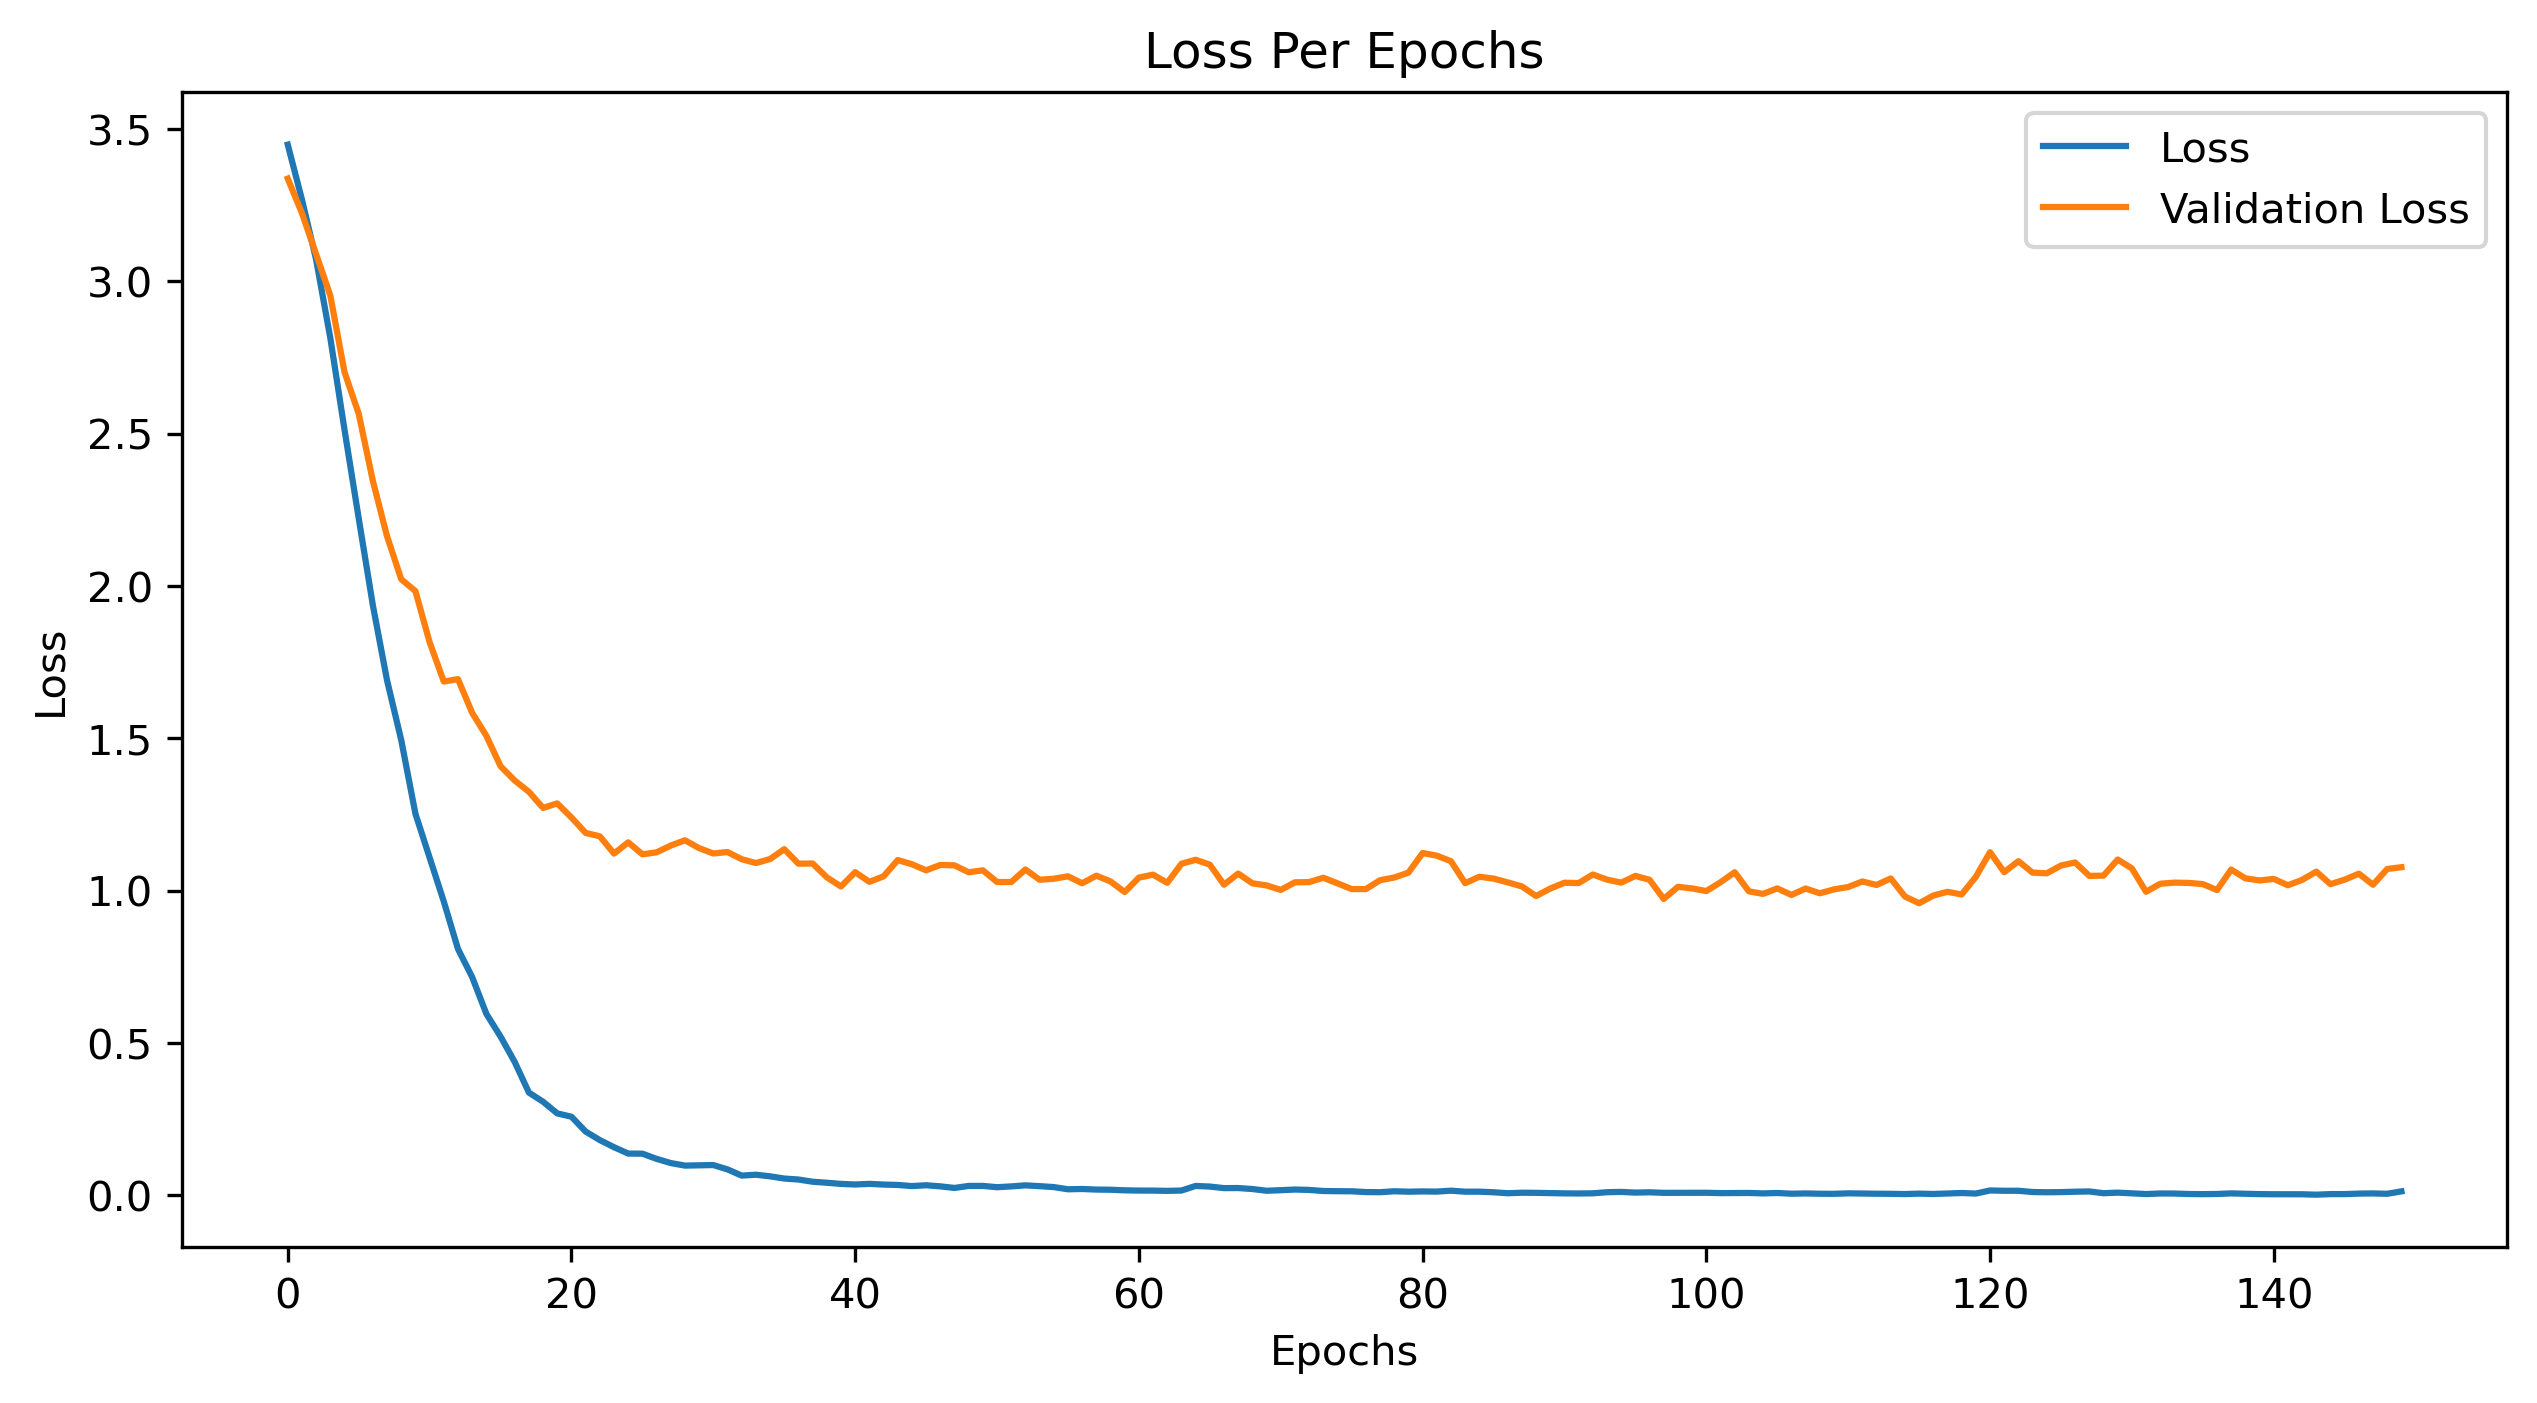

In [49]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


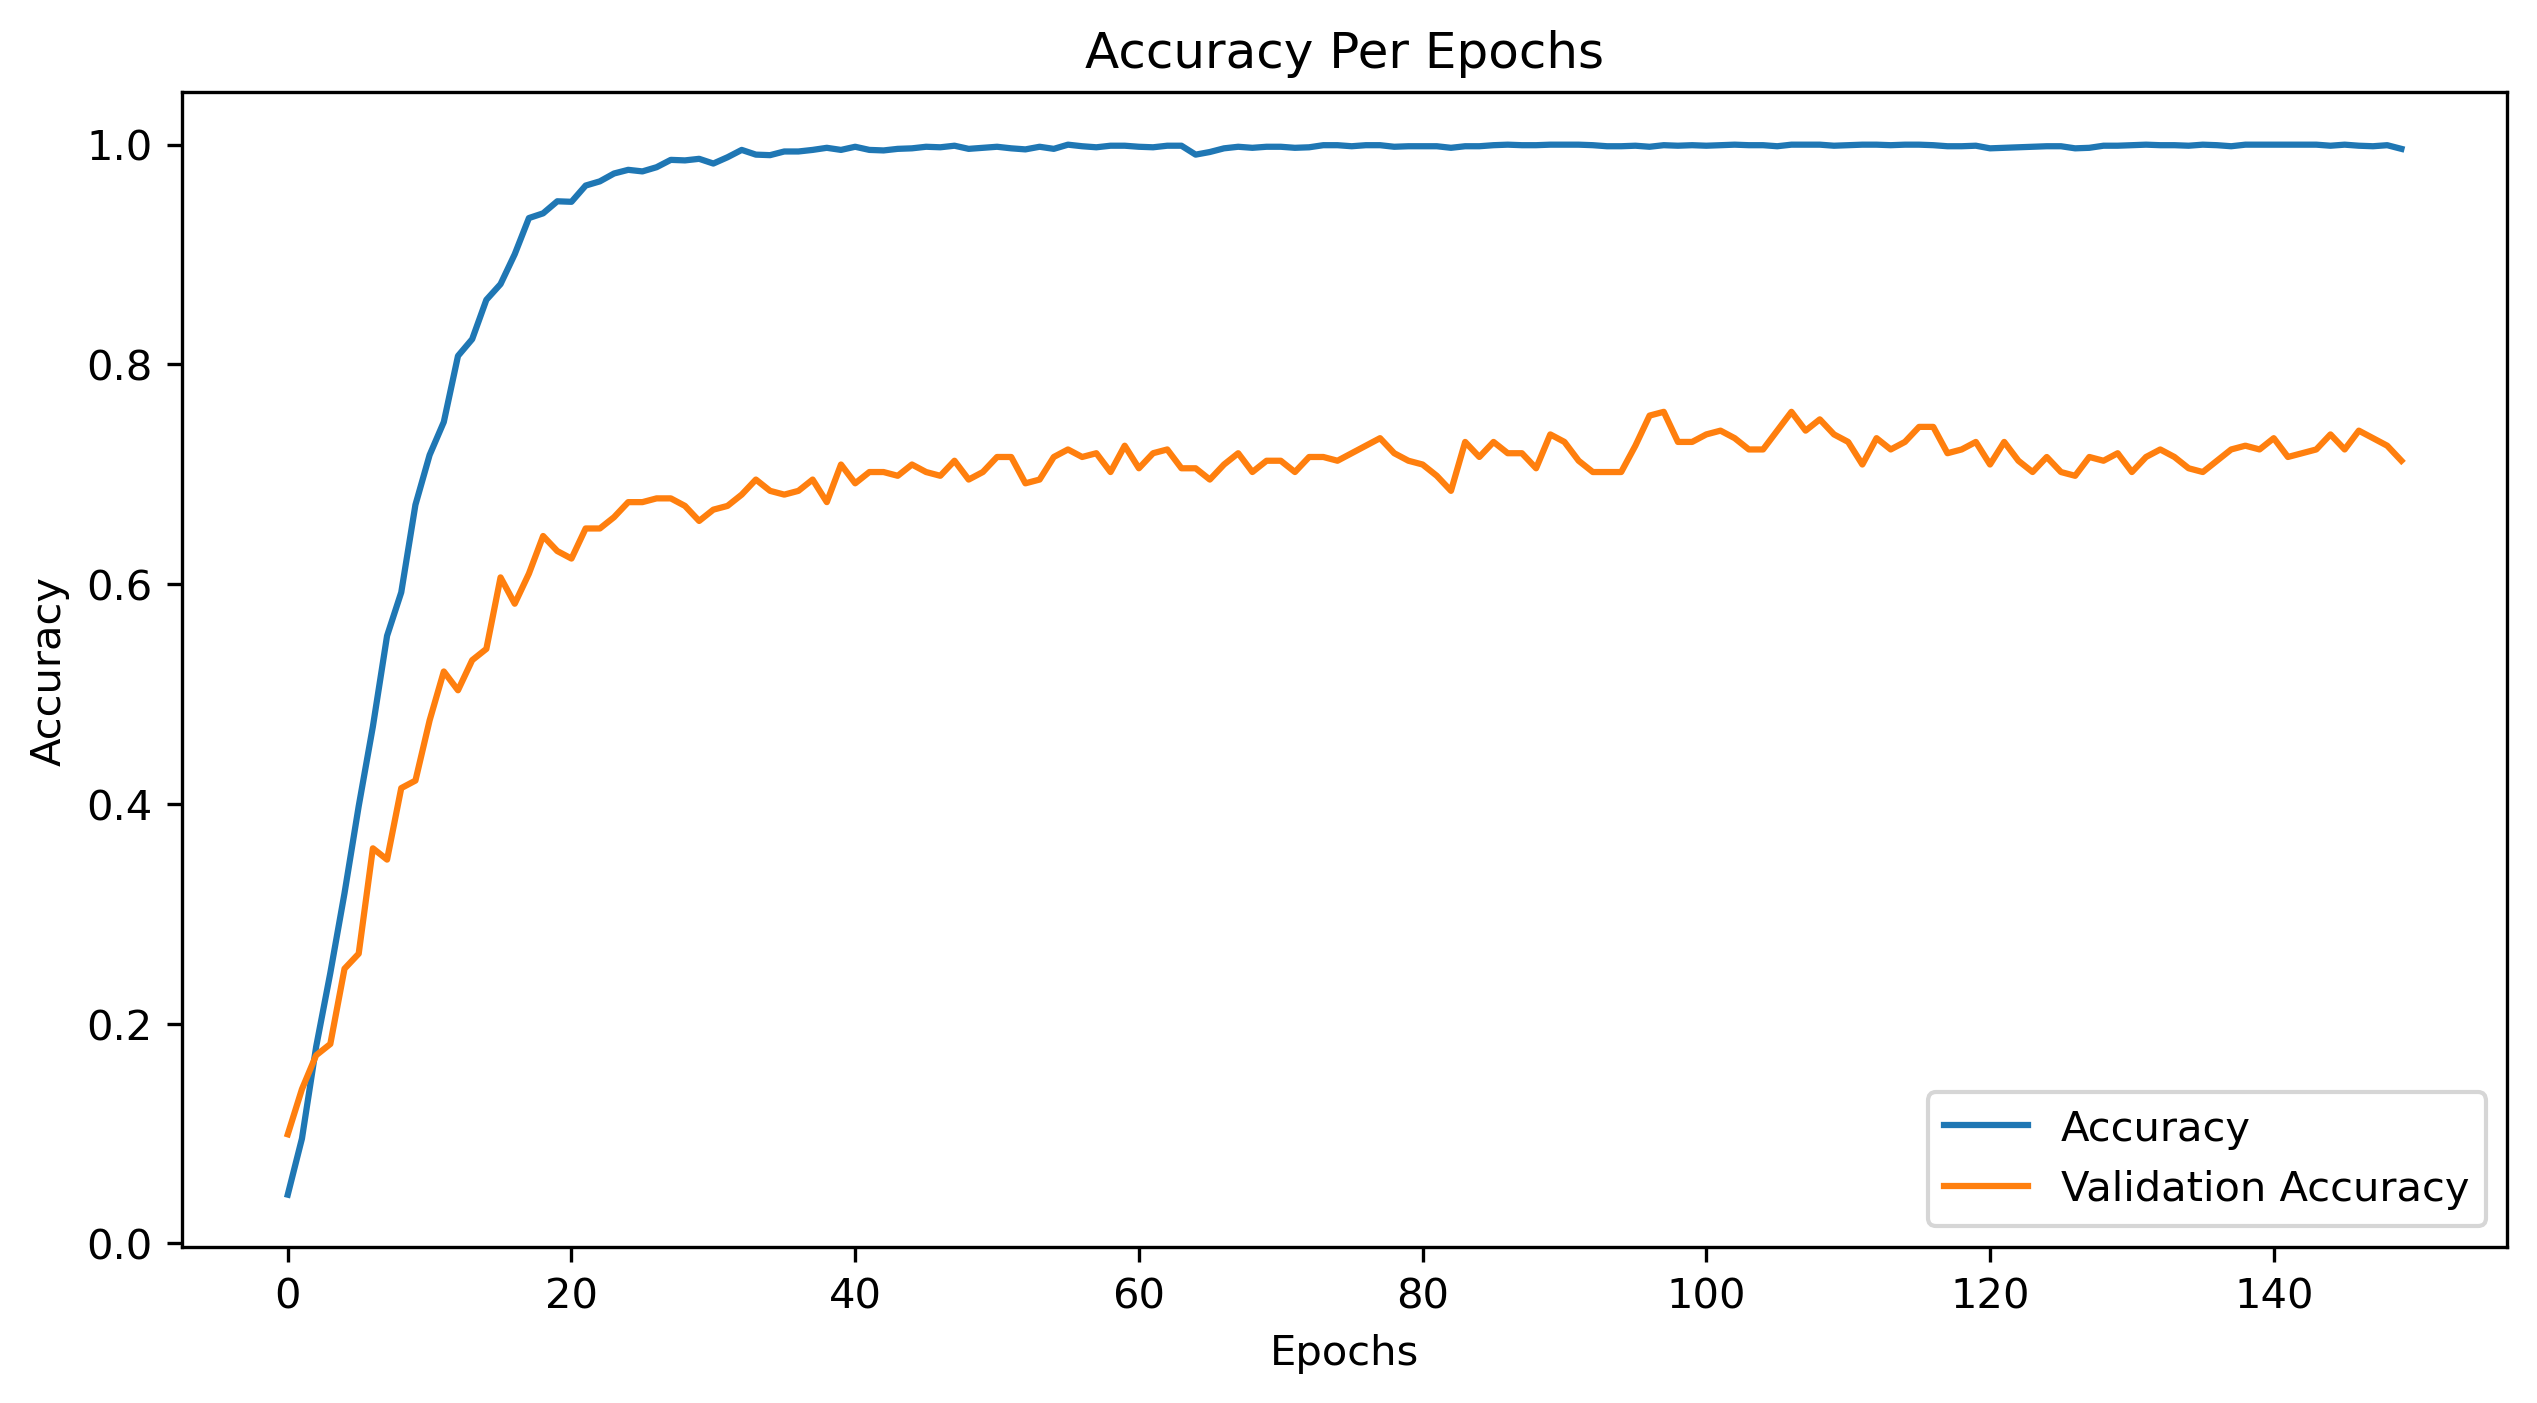

In [50]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [51]:
acc_m3 = CNN2D_Model.evaluate(xtest, yTest, verbose=0)
t0 = time.time()
y_pred_m3 = CNN2D_Model.predict(xtest, verbose=0)
pred_m3 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN2D", acc_m3[1] * 100, train_m3, pred_m3]], columns=log_cols
)
log = log.append(log_entry)


## CNN2D Prediction Function


In [52]:

def CNN2D_Prediction(file_name):
    
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)
    print(feature)
    
    feature_scaled = np.mean(feature.T, axis=0)
    
    prediction_feature = np.array([feature_scaled])
    
    final_prediction_feature = prediction_feature.reshape(
        prediction_feature.shape[0], 16, 8, 1
    )
    
    predicted_vector = np.argmax(CNN2D_Model.predict(final_prediction_feature), axis=-1)
    
    predicted_class = le.inverse_transform(predicted_vector)
    
    print("CNN2D has predicted the class as  --> ", predicted_class[0])


## Testing the Model on Sample audio


In [53]:
# File name
file_name = '0040.wav'
# get the output
CNN2D_Prediction(file_name)
# play the file
ipd.Audio(file_name)


[[-3.51332123e+02 -3.25917633e+02 -3.27023468e+02 ... -3.27128815e+02
  -3.19931580e+02 -3.29153076e+02]
 [ 7.97952271e+01  8.80608215e+01  8.52180939e+01 ...  8.93345337e+01
   8.81934204e+01  9.02708206e+01]
 [ 1.58275309e+01  1.02366295e+01  9.21125793e+00 ...  1.15287218e+01
   4.28143311e+00  1.16976299e+01]
 ...
 [ 1.95903301e-01  3.66890907e-01  1.19125462e+00 ...  2.27118111e+00
   1.42892361e+00  9.65691566e-01]
 [-1.19588852e-01 -4.14642811e-01 -4.69909191e-01 ... -6.77003860e-02
   1.12748027e+00  1.72705412e+00]
 [-1.86841965e+00 -2.05498886e+00 -1.52046204e+00 ...  1.34761429e+00
   1.59566498e+00  1.03889465e+00]]
1/1 [==============================] - 0s 119ms/step
CNN2D has predicted the class as  -->  he


# **CNN 3d**


In [114]:
xTrain_3d = xTrain.reshape(xTrain.shape[0], 16, 8, 1, 1)
xTest_3d = xTest.reshape(xTest.shape[0], 16, 8, 1, 1)

print("The Shape of X Train", xTrain_3d.shape)
print("The Shape of Y Train", yTrain.shape)
print("The Shape of X Test", xTest_3d.shape)
print("The Shape of Y Test", yTest.shape)

The Shape of X Train (2096, 16, 8, 1, 1)
The Shape of Y Train (2096, 30)
The Shape of X Test (292, 16, 8, 1, 1)
The Shape of Y Test (292, 30)


In [115]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense


In [142]:
CNN3D_Model = Sequential()
CNN3D_Model.add(Conv3D(64, kernel_size=(3, 3, 1), activation="relu", input_shape=(16, 8, 1, 1)))
CNN3D_Model.add(MaxPooling3D(pool_size=(2, 2, 1)))
CNN3D_Model.add(Conv3D(128, kernel_size=(3, 3, 1), padding="same", activation="relu"))
CNN3D_Model.add(MaxPooling3D(pool_size=(2, 2, 1)))
CNN3D_Model.add(Dropout(0.3))
CNN3D_Model.add(Flatten())
CNN3D_Model.add(Dense(512, activation="relu"))
CNN3D_Model.add(Dense(1024, activation="relu"))
CNN3D_Model.add(Dense(30, activation="softmax"))
CNN3D_Model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_45 (Conv3D)          (None, 14, 6, 1, 64)      640       
                                                                 
 max_pooling3d_46 (MaxPoolin  (None, 7, 3, 1, 64)      0         
 g3D)                                                            
                                                                 
 conv3d_46 (Conv3D)          (None, 7, 3, 1, 128)      73856     
                                                                 
 max_pooling3d_47 (MaxPoolin  (None, 3, 1, 1, 128)     0         
 g3D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 3, 1, 1, 128)      0         
                                                                 
 flatten_27 (Flatten)        (None, 384)             

In [143]:
CNN3D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


In [144]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

In [145]:
t0 = time.time()

history = CNN3D_Model.fit(
    xTrain_3d, yTrain,
    epochs=150,  
    batch_size=256,  
    validation_data=(xTest_3d, yTest),
    callbacks=[early_stopping]  
)
train_hist_m3 = pd.DataFrame(history.history)
train_m3 = round(time.time() - t0, 3)


Epoch 1/150
9/9 [==============================] - 1s 96ms/step - loss: 4.3192 - accuracy: 0.0281 - val_loss: 3.3950 - val_accuracy: 0.0548
Epoch 2/150
9/9 [==============================] - 0s 15ms/step - loss: 3.3934 - accuracy: 0.0520 - val_loss: 3.3358 - val_accuracy: 0.1164
Epoch 3/150
9/9 [==============================] - 0s 15ms/step - loss: 3.3305 - accuracy: 0.0811 - val_loss: 3.2329 - val_accuracy: 0.1507
Epoch 4/150
9/9 [==============================] - 0s 14ms/step - loss: 3.2120 - accuracy: 0.1011 - val_loss: 3.0424 - val_accuracy: 0.1370
Epoch 5/150
9/9 [==============================] - 0s 12ms/step - loss: 3.0472 - accuracy: 0.1417 - val_loss: 2.9162 - val_accuracy: 0.1712
Epoch 6/150
9/9 [==============================] - 0s 13ms/step - loss: 2.9367 - accuracy: 0.1407 - val_loss: 2.8667 - val_accuracy: 0.1815
Epoch 7/150
9/9 [==============================] - 0s 16ms/step - loss: 2.8557 - accuracy: 0.1636 - val_loss: 2.7874 - val_accuracy: 0.1918
Epoch 8/150
9/9 [===

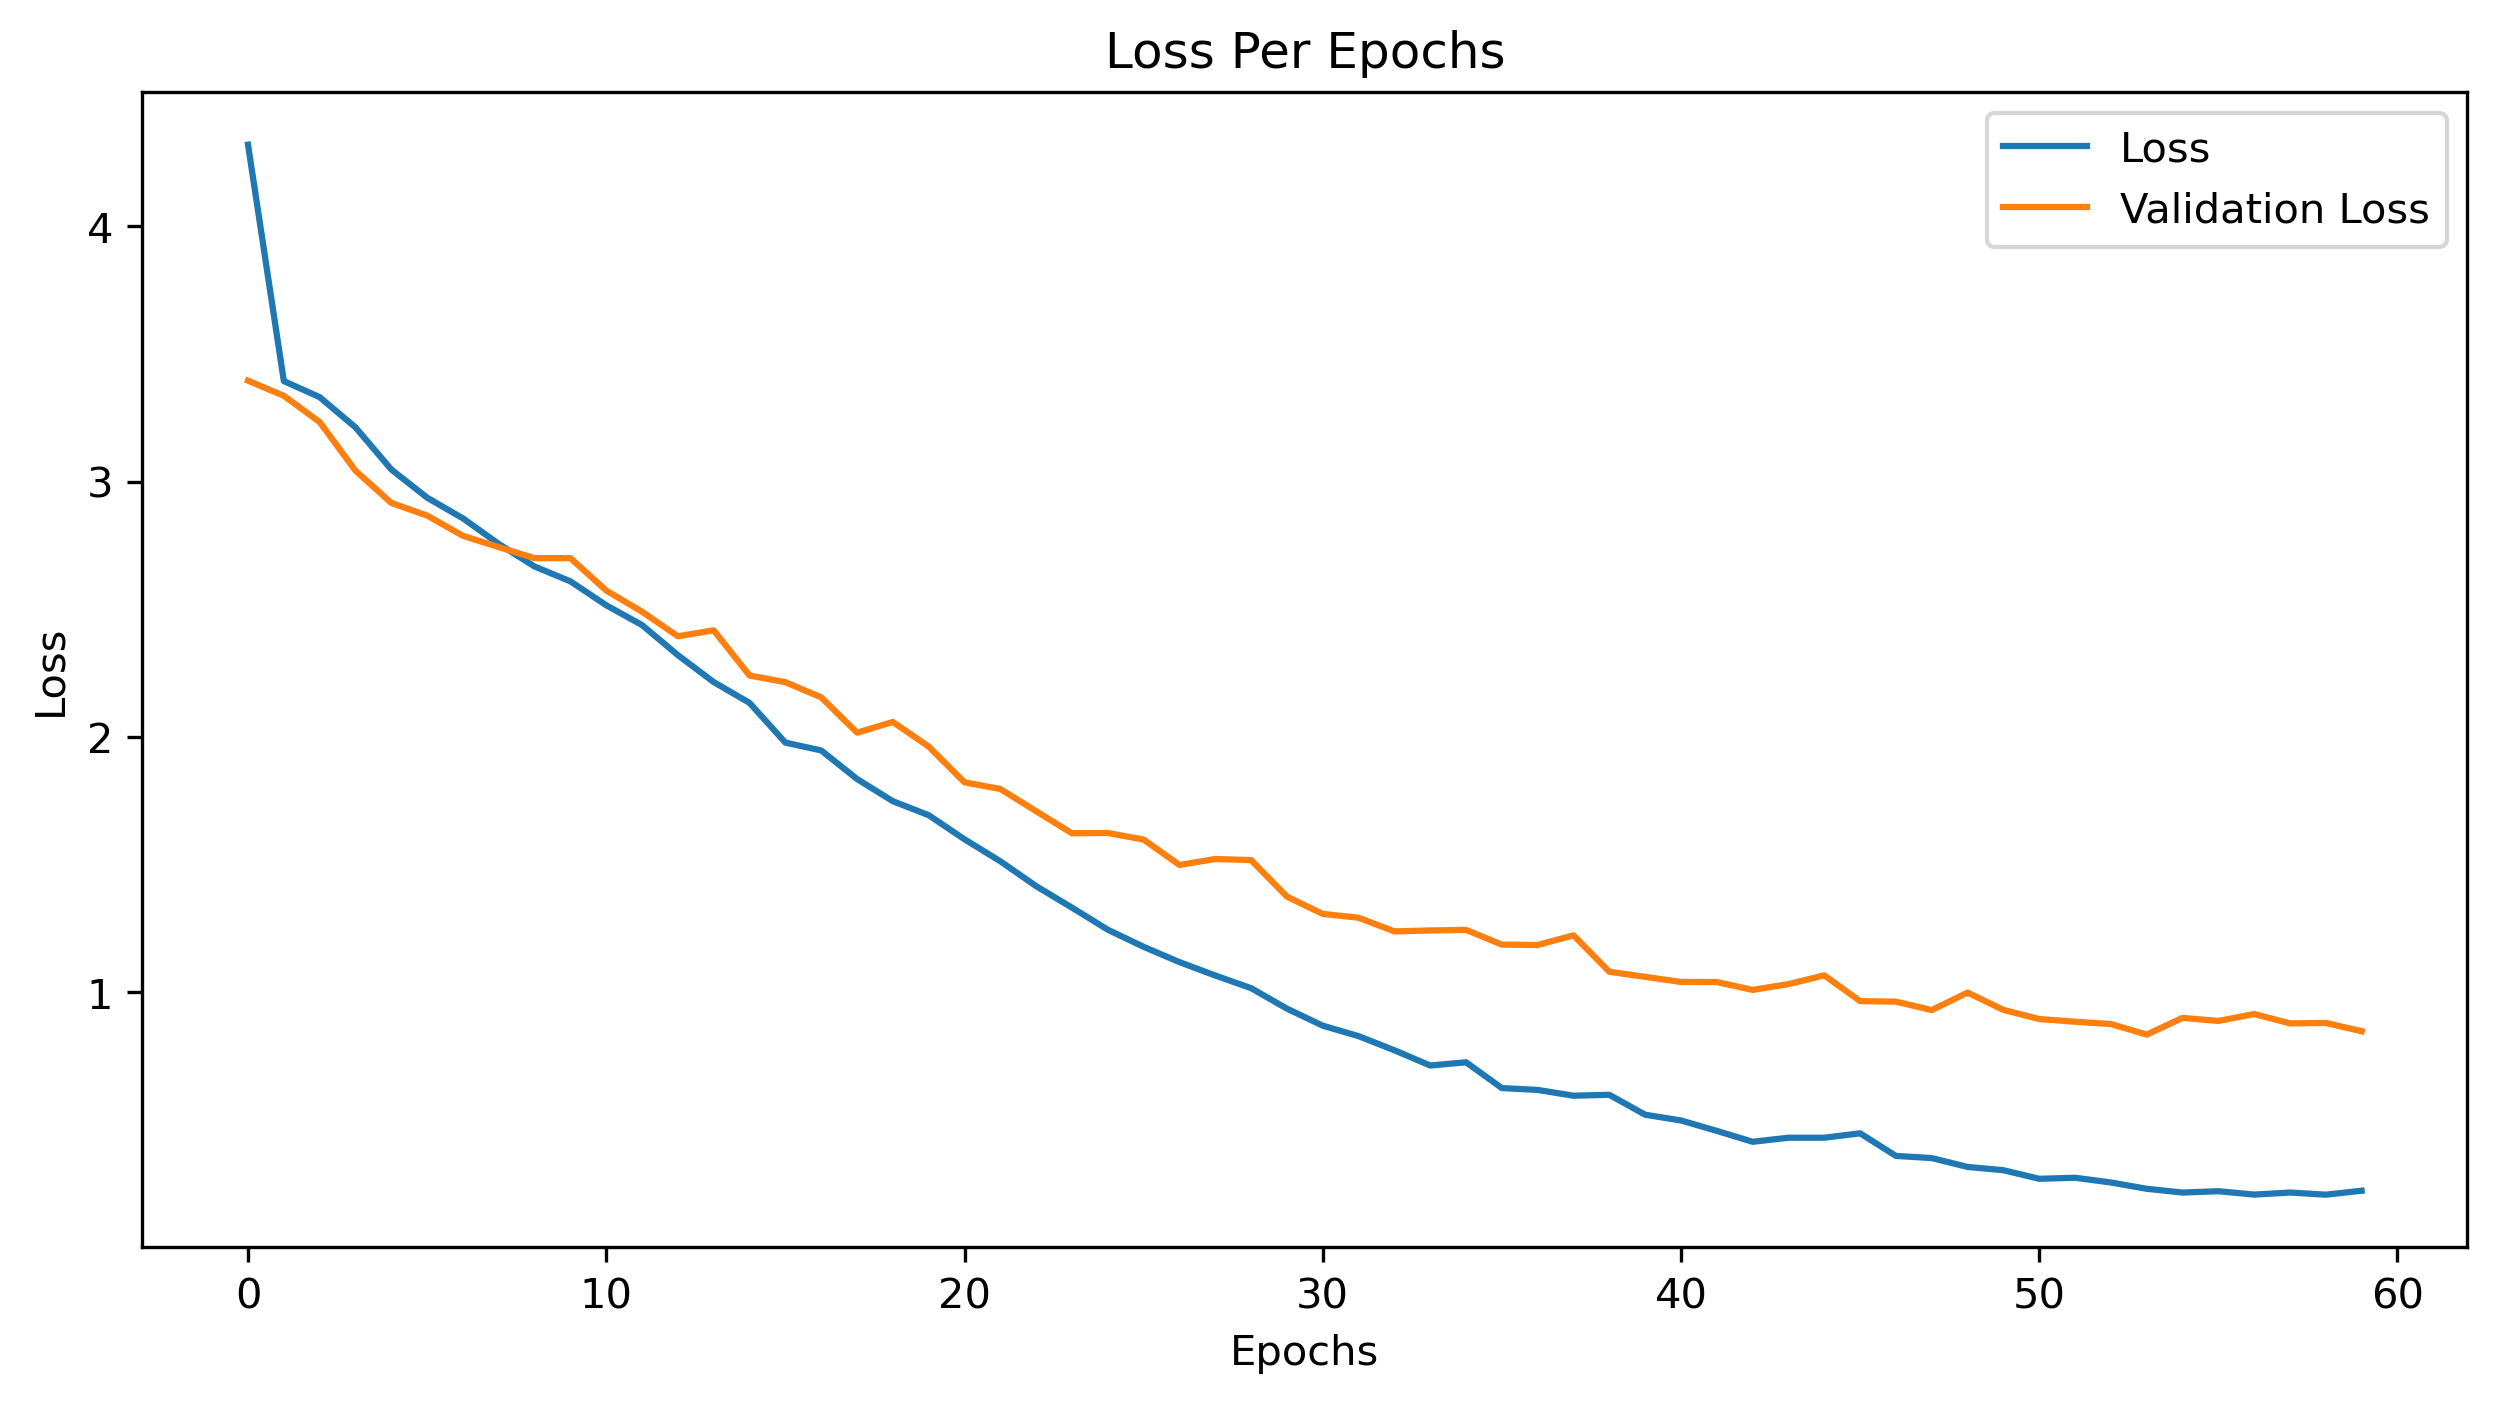

In [146]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [150]:
CNN3D_Model.save("audio_classification_model.h5")

print("Model saved successfully.")

Model saved successfully.


In [166]:
acc_m3 = CNN3D_Model.evaluate(xTest_3d, yTest, verbose=3)
t0 = time.time()
y_pred_m3 = CNN3D_Model.predict(xTest_3d, verbose=0)
pred_m3 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN3D", acc_m3[1] * 100, train_m3, pred_m3]], columns=log_cols
)
log = log.append(log_entry)


In [155]:

def CNN3D_Prediction(file_name):
    
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)
    print(feature)
    
    feature_scaled = np.mean(feature.T, axis=0)
    
    prediction_feature = np.array([feature_scaled])
    
    final_prediction_feature = prediction_feature.reshape(
        prediction_feature.shape[0], 16, 8, 1
    )
    
    predicted_vector = np.argmax(CNN3D_Model.predict(final_prediction_feature), axis=-1)
    
    predicted_class = le.inverse_transform(predicted_vector)
    
    print("CNN3D has predicted the class as  --> ", predicted_class[0])


In [185]:

file_name = meta_data['File Name'][1790]
# file_name = r""


CNN3D_Prediction(file_name)

ipd.Audio(file_name)


[[-2.53148926e+02 -2.19353317e+02 -2.34435226e+02 ... -2.31517807e+02
  -2.11686630e+02 -2.28106888e+02]
 [ 8.89734039e+01  9.27064209e+01  9.30609436e+01 ...  1.01249786e+02
   1.06799011e+02  1.00898399e+02]
 [-2.76319599e+01 -3.26720505e+01 -2.47184601e+01 ... -2.10705376e+01
  -2.16316128e+01 -1.50744743e+01]
 ...
 [-9.79309082e-02  8.81958961e-01  1.62632656e+00 ... -1.17023659e+00
  -5.29894829e-01  1.30817413e-01]
 [-1.00336075e-01  1.31835651e+00  2.03619862e+00 ...  4.67075443e+00
   1.10465050e+00  1.03836536e-01]
 [-1.30908966e-01 -6.68968201e-01 -1.87197876e+00 ...  3.20040131e+00
  -4.21066284e-01 -2.51098633e+00]]
1/1 [==============================] - 0s 25ms/step
CNN3D has predicted the class as  -->  people
